In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.linear_model import OLS
from datetime import datetime as dt
from typing import \
    List, \
    Dict, \
    Callable
import math
from scipy.stats import norm


In [2]:
article_nbr = 3
symbol = 'CL'

final_df = pd.read_csv('../data/{}.csv'.format(symbol), 
                 index_col=0, 
                 header=0,
                 parse_dates=[0],
                 date_format='%Y-%m-%d')


# Vol Normalized Returns and Features

In [3]:
# our signals are based on the close
# calculate the vol, inclusing a short vol and a long vol floor
final_df['close_log_ret'] = np.log(final_df['CLOSE']) - np.log(final_df['CLOSE'].shift(1))
final_df['close_log_ret_sqr'] = final_df['close_log_ret'].pow(2)
final_df['close_log_ret_sqr_short'] = final_df['close_log_ret_sqr'].ewm(span=42, min_periods=42).mean()
final_df['close_vol_short'] = final_df['close_log_ret_sqr_short'].pow(0.5)
# final_df['close_log_ret_sqr_long'] = final_df['close_log_ret_sqr'].ewm(span=504, min_periods=42).mean()
# final_df['close_vol_long'] = final_df['close_log_ret_sqr_long'].pow(0.5)
# final_df['close_vol_long_floor'] = 0.5 * final_df['close_vol_long']
# final_df['close_vol'] = final_df[['close_vol_short', 'close_vol_long_floor']].max(axis=1)
final_df['close_vol'] = final_df['close_vol_short']
final_df['close_ret_sr'] = final_df['close_log_ret'] / final_df['close_vol']


# EWMAC_32_128_NVOL
final_df['close_log_ret_sr_cumsum'] = final_df['close_ret_sr'].cumsum()
final_df['close_lsr_ewma_32'] = final_df['close_log_ret_sr_cumsum'].ewm(span=32, min_periods=32).mean()
final_df['close_lsr_ewma_128'] = final_df['close_log_ret_sr_cumsum'].ewm(span=128, min_periods=128).mean()
# final_df['close_lsr_ewmac_32_128_pct'] = (final_df['close_lsr_ewma_32'] - final_df['close_lsr_ewma_128']) \
#         / ((final_df['close_lsr_ewma_32'].abs() + final_df['close_lsr_ewma_128'].abs()) / 2)
final_df['close_lsr_ewmac_32_128'] = (final_df['close_lsr_ewma_32'] - final_df['close_lsr_ewma_128'])


# forward return is open to open
final_df['open_log_ret'] = np.log(final_df['OPEN']) - np.log(final_df['OPEN'].shift(1))
final_df['1df_open_log_ret'] = final_df['open_log_ret'].shift(-2)
final_df['1df_open_log_sr'] = (0.2 / math.sqrt(252)) * final_df['1df_open_log_ret'] / final_df['close_vol']



# y = f(x)

In [4]:
x_axis_col_name = 'close_lsr_ewmac_32_128'
y_axis_col_name = '1df_open_log_sr'



### Scatter plot with original distributions

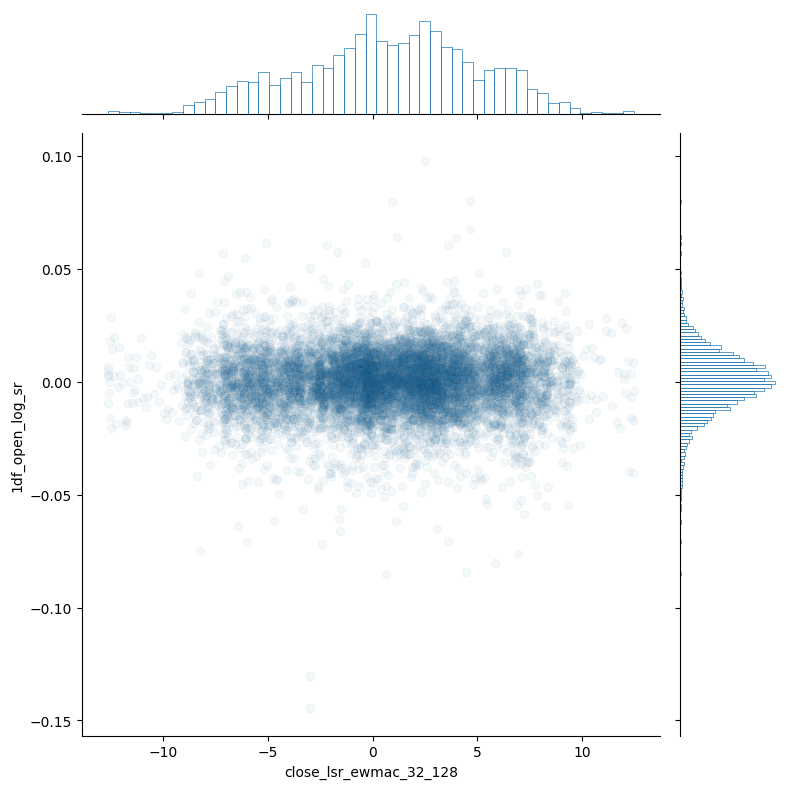

In [35]:

# plt.scatter(final_df[x_axis_col_name], final_df[y_axis_col_name], alpha=0.01)
# # plt.title('Year 2000')
# plt.xlabel(x_axis_col_name)
# plt.ylabel(y_axis_col_name)
# plt.show()


x, y = final_df[x_axis_col_name], final_df[y_axis_col_name]

g = sns.JointGrid(height=8)
sns.scatterplot(x=x, y=y, alpha=.05, edgecolor=".2", linewidth=0.5, ax=g.ax_joint)
sns.histplot(x=x, fill=False, linewidth=0.5, ax=g.ax_marg_x)
sns.histplot(y=y, fill=False, linewidth=0.5, ax=g.ax_marg_y)
# sns.lineplot(data=final_df, x=x_axis_col_name, y=x_axis_col_name, ax=g.ax_joint)
plt.tight_layout()
plt.savefig('../output/{}_{}_scatterplot_original_distributions.png'.format(symbol, article_nbr))
# plt.show()


### Scatter plot with uniform distributions

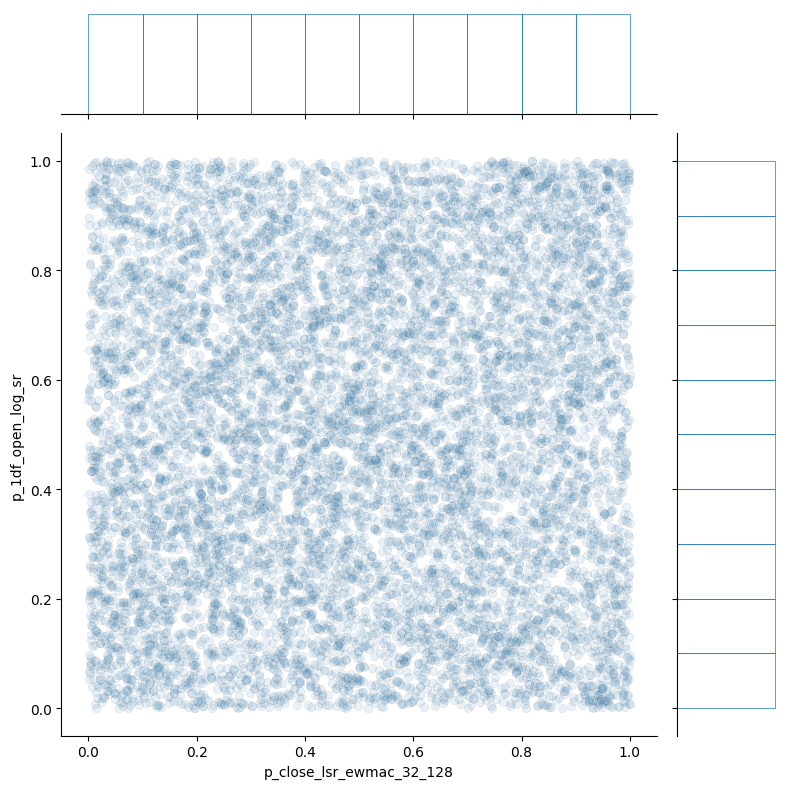

In [37]:
# CREATE UNIFORM DISTRIBUTIONS FOR X and Y
# create %-ile values coresponding to x_axis_col_name values
final_df.sort_values(by=[x_axis_col_name], inplace=True)
final_df['p_'+x_axis_col_name] = np.arange(len(final_df)) / (len(final_df) - 1)

# create %-ile values coresponding to y_axis_col_name values
final_df.sort_values(by=[y_axis_col_name], inplace=True)
final_df['p_'+y_axis_col_name] = np.arange(len(final_df)) / (len(final_df) - 1)

# sort back to index (date) 
final_df.sort_index(inplace=True)


# # plot a scatterplot of the %-ile values of x_axis_col_name and y_axis_col_name
# x, y = final_df['p_'+x_axis_col_name], final_df['p_'+y_axis_col_name]
# plt.scatter(x, y, alpha=0.08)
# plt.xlabel(x_axis_col_name)
# plt.ylabel(y_axis_col_name)
# plt.show()


# x, y = final_df['p_'+x_axis_col_name], final_df['p_'+y_axis_col_name]
x, y = final_df['p_'+x_axis_col_name], final_df['p_'+y_axis_col_name]
g = sns.JointGrid(height=8)
sns.scatterplot(x=x, y=y, alpha=.1, edgecolor=".2", linewidth=0.5, ax=g.ax_joint)
sns.histplot(x=x, fill=False, linewidth=0.5, ax=g.ax_marg_x, bins=10)
sns.histplot(y=y, fill=False, linewidth=0.5, ax=g.ax_marg_y, bins=10)
# sns.lineplot(data=final_df, x='p_'+x_axis_col_name, y='p_'+x_axis_col_name, ax=g.ax_joint)
# sns.lineplot(x=np.arange(0.05, 1.05, 0.1), y=y_hats, color='orange', ax=g.ax_joint)
plt.tight_layout()
plt.savefig('../output/{}_{}_scatterplot_uniform_distributions.png'.format(symbol, article_nbr))


### Create bin assignments on X and Y

In [38]:
def create_y_hat_index(bin_col_name_list: List[str], bin_count: int) -> pd.Index:
    """
    Unlike the index returned by the groupby() call, this index is guaranteed
    to not be missing any values; it completely spans the space of all bins in
    every dimension/feature

    :return: pd.Index
    """
    if len(bin_col_name_list) > 1:
        # calculate coordinates per each dimension
        dims_coordinates_list = []
        for d in range(len(bin_col_name_list)):
            # create an sequence of length mask_bin_counts[d]
            dim_coordinates = np.arange(bin_count)
            # store this sequence of distances for this dimension
            dims_coordinates_list.append(dim_coordinates)

        result = pd.MultiIndex.from_product(dims_coordinates_list, names=bin_col_name_list)
    else:
        # if we only have a single feature, then we are going to use a RangeIndex
        result = pd.RangeIndex(0, bin_count, 1, name=bin_col_name_list[0])

    return result


In [39]:
bin_count = 10
bin_col_name_list = []

final_df.sort_index(inplace=True)

x_bin_col_name = 'bins_' + x_axis_col_name
y_bin_col_name = 'bins_' + y_axis_col_name
bin_col_name_list.append(x_bin_col_name)
bin_col_name_list.append(y_bin_col_name)

# bin x feature
x_bin_assignments, x_bin_edges = pd.qcut(final_df[x_axis_col_name],
                                          q=bin_count,
                                          retbins=True,
                                          labels=False,
                                          duplicates='drop')
final_df[x_bin_col_name] = x_bin_assignments

# bin y target
y_bin_assignments, y_bin_edges = pd.qcut(final_df[y_axis_col_name],
                                          q=bin_count,
                                          retbins=True,
                                          labels=False,
                                          duplicates='drop')
final_df[y_bin_col_name] = y_bin_assignments

# print(final_df)


In [40]:
# Create a DataFrame with a count of data point in each 10x10 bin

# mutual_information (mi)
mi_count = final_df.groupby(bin_col_name_list)[y_axis_col_name].count()

mi_df = pd.DataFrame(index=create_y_hat_index(bin_col_name_list, bin_count))
mi_df['count'] = mi_count
mi_df = mi_df.reset_index()
# print(mi_df)


In [41]:
# # calculate the y_hat for each bin
# y_hats = final_df.groupby(x_bin_col_name)['p_'+y_axis_col_name].mean()


In [42]:
mi_pivot_df = mi_df.pivot(index=bin_col_name_list[1], columns=bin_col_name_list[0], values='count')
mi_pivot_df = mi_pivot_df.iloc[::-1]
print(mi_pivot_df)


bins_close_lsr_ewmac_32_128    0    1    2    3    4    5    6    7    8    9
bins_1df_open_log_sr                                                         
9                            106   93  101   86   74   97   97  114  123  121
8                             84   97   89  110   94  127  100  100  105  106
7                             95  104   95  107  109   99  104   90   94  114
6                             97   97  107  116   90  101   90  107  105  102
5                             85   94  108  101  125  115   94   99  105   85
4                            111   91  100  105  100  110  133   93   87   82
3                            100  113  119   95  110   93  112   83  105   82
2                            117  102  109  100  112   89   90  106   90   96
1                            111  102   95   89  101   89  109  115  101  100
0                            106  119   89  103   96   90   83  105   97  124


In [43]:
# for i in range(len(mi_pivot_df)):
#     print('{}, sum: {}, mean: {}, std: {}'.format(i, mi_pivot_df[i].sum(), mi_pivot_df[i].mean(), mi_pivot_df[i].std()))


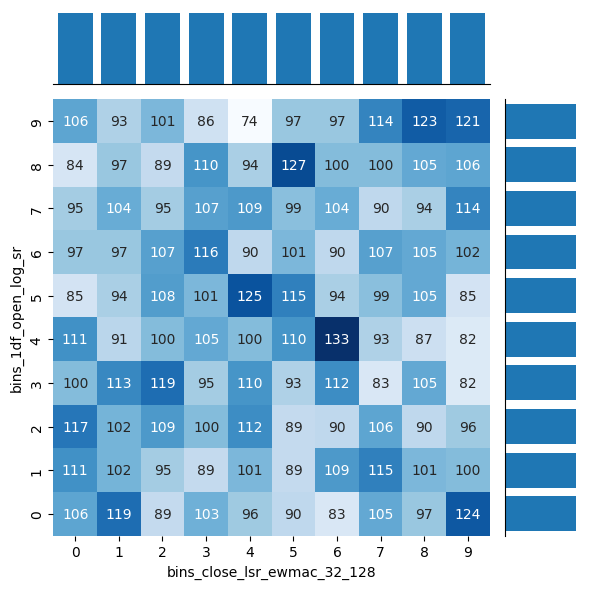

In [47]:
g = sns.jointplot(data=mi_df, 
                  x=bin_col_name_list[0], 
                  y=bin_col_name_list[1], 
                  kind='hist', 
                  bins=(len(bin_col_name_list[0]), len(bin_col_name_list[1])))
g.ax_marg_y.cla()
g.ax_marg_x.cla()
sns.heatmap(data=mi_pivot_df, ax=g.ax_joint, cbar=False, cmap='Blues', annot=True, fmt="d")
g.ax_marg_y.barh(np.arange(0.5, 10), mi_pivot_df.sum(axis=1)/len(bin_col_name_list[0]))
g.ax_marg_x.bar(np.arange(0.5, 10), mi_pivot_df.sum(axis=0)/len(bin_col_name_list[1]))

# remove ticks between heatmao and histograms
g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
# remove ticks showing the heights of the histograms
g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

plt.tight_layout()
plt.savefig('../output/{}_{}_heatmap_bin_data_count.png'.format(symbol, article_nbr))

# plt.show()

In [45]:
# calculate the bin y_hat values
y_hats = final_df.groupby(x_bin_col_name)[y_axis_col_name].mean()
y_hat_df = y_hats.to_frame()
y_hat_df.columns = ['y_hat']
y_hat_df = y_hat_df.reset_index()


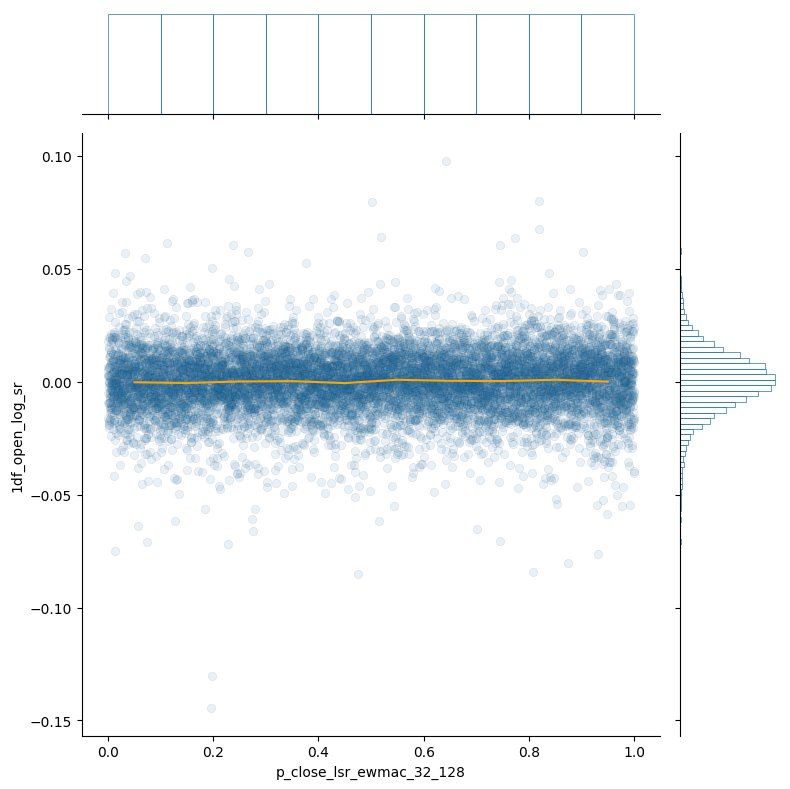

In [46]:
# calculate the y_hat for each bin
y_hats = final_df.groupby(x_bin_col_name)['p_'+y_axis_col_name].mean()

# x, y = final_df['p_'+x_axis_col_name], final_df['p_'+y_axis_col_name]
x, y = final_df['p_'+x_axis_col_name], final_df[y_axis_col_name]
g = sns.JointGrid(height=8)
sns.scatterplot(x=x, y=y, alpha=.1, edgecolor=".2", linewidth=0.5, ax=g.ax_joint)
sns.histplot(x=x, fill=False, linewidth=0.5, ax=g.ax_marg_x, bins=10)
sns.histplot(y=y, fill=False, linewidth=0.5, ax=g.ax_marg_y, bins=100)
# sns.lineplot(data=final_df, x='p_'+x_axis_col_name, y='p_'+x_axis_col_name, ax=g.ax_joint)
sns.lineplot(x=np.arange(0.05, 1.05, 0.1), y=y_hat_df['y_hat'], color='orange', ax=g.ax_joint)

plt.tight_layout()
plt.savefig('../output/{}_{}_scatterplot_uniform_x_original_y.png'.format(symbol, article_nbr))


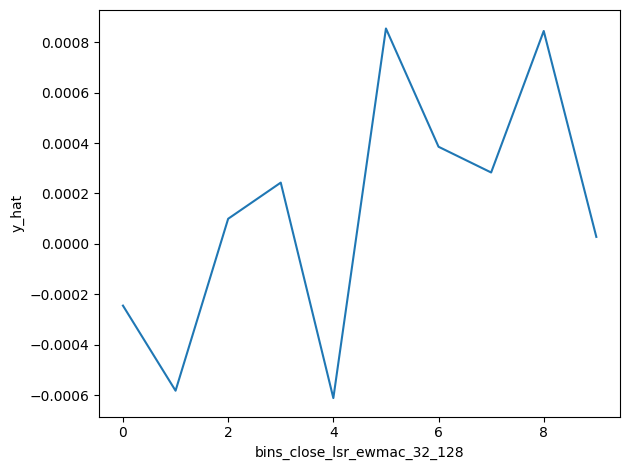

In [48]:
sns.lineplot(data=y_hat_df, x=x_bin_col_name, y='y_hat')

plt.tight_layout()
plt.savefig('../output/{}_{}_bin_model.png'.format(symbol, article_nbr))


In [17]:
# remove rows without values for the x_axis_col_name
final_df = final_df[final_df[x_axis_col_name].notna()].copy()

# assign y_hat value based on x_axis_col_name bin to each data row

data_y_hat_df = final_df[[x_bin_col_name]].merge(y_hat_df, left_on=x_bin_col_name, right_on=x_bin_col_name)
data_y_hat_df.index = final_df.index

final_df['y_hat'] = data_y_hat_df['y_hat']
# print(data_y_hat_df)
# print(final_df['y_hat'])



In [18]:
# CALCULATE TRADING SYSTEM PERFORMANCE

# Buy & Hold model
bh_model_ann_vol = math.sqrt(252) * final_df[y_axis_col_name]['1985':].std()
bh_model_vol_mult = 0.2 / bh_model_ann_vol
final_df['bh_model_returns'] = bh_model_vol_mult * final_df[y_axis_col_name]
bh_model_sr = 252 * final_df['bh_model_returns']['1985':].mean() / 0.2


# bin model
final_df['bin_model_returns'] = final_df[y_axis_col_name] * final_df['y_hat']
bin_model_ann_vol = math.sqrt(252) * final_df['bin_model_returns']['1985':].std()
bin_model_vol_mult = 0.2 / bin_model_ann_vol
final_df['bin_model_returns'] = bin_model_vol_mult * final_df['bin_model_returns']
bin_model_sr = 252 * final_df['bin_model_returns']['1985':].mean() / 0.2

# linear model
final_df['linear_model_returns'] = final_df[y_axis_col_name] * final_df[x_axis_col_name]
lin_model_ann_vol = math.sqrt(252) * final_df['linear_model_returns']['1985':].std()
lin_model_vol_mult = 0.2 / lin_model_ann_vol
final_df['linear_model_returns'] = lin_model_vol_mult * final_df['linear_model_returns']
lin_model_sr = 252 * final_df['linear_model_returns']['1985':].mean() / 0.2

# classifier model
def binary_classifier(row):
    if row[x_axis_col_name] > 0:
        val = 1
    elif row[x_axis_col_name] < 0:
        val = -1
    else:
        val = 0
    return val
class_col_name = '{}_class'.format(x_axis_col_name)
final_df[class_col_name] = final_df.apply(binary_classifier, axis=1)
final_df['class_model_returns'] = final_df[y_axis_col_name] * final_df[class_col_name]
class_model_ann_vol = math.sqrt(252) * final_df['class_model_returns']['1985':].std()
class_model_vol_mult = 0.2 / class_model_ann_vol
final_df['class_model_returns'] = class_model_vol_mult * final_df['class_model_returns']
class_model_sr = 252 * final_df['class_model_returns']['1985':].mean() / 0.2


final_df['bin_model_pnl'] = final_df['bin_model_returns']['1985':].cumsum()
final_df['linear_model_pnl'] = final_df['linear_model_returns']['1985':].cumsum()
final_df['class_model_pnl'] = final_df['class_model_returns']['1985':].cumsum()
final_df['bh_pnl'] = final_df['bh_model_returns']['1985':].cumsum()



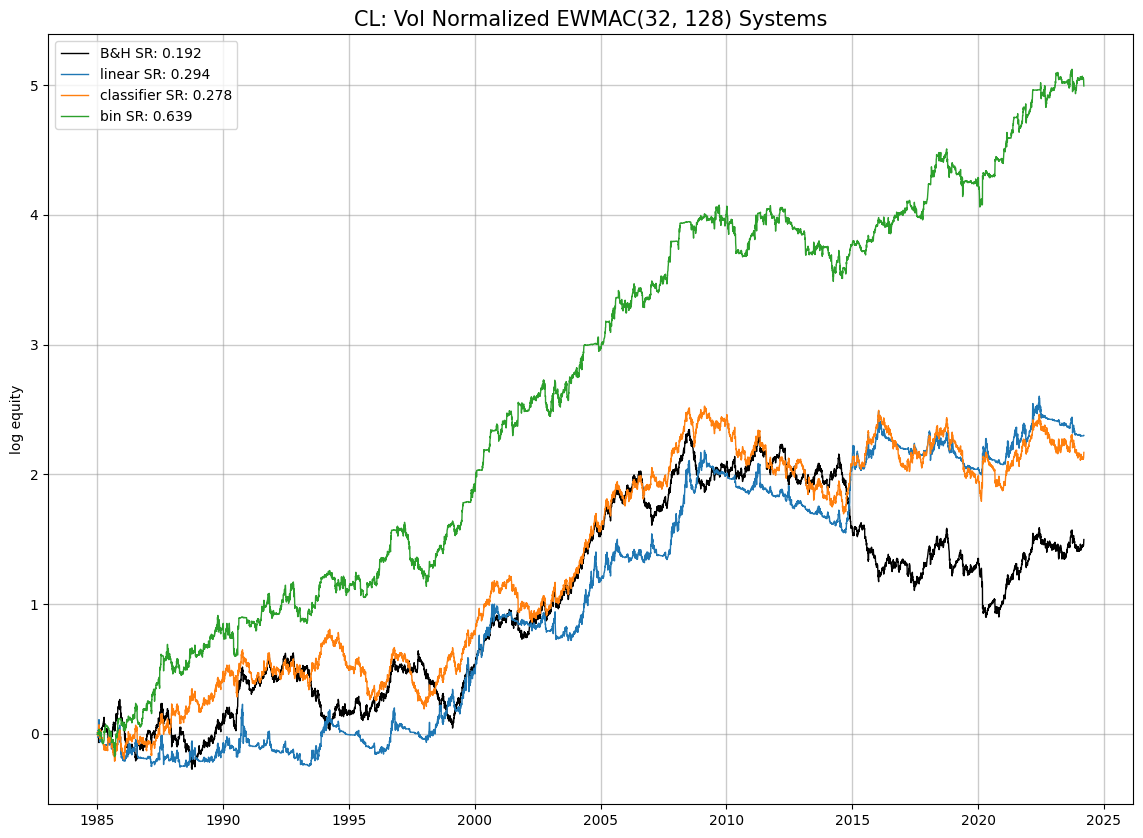

In [27]:
# CHART TRADING SYSTEM PERFORMANCE

fig, ax1 = plt.subplots(figsize=(14, 10))
plt.title( '{}: Vol Normalized EWMAC(32, 128) Systems'.format(symbol), fontsize=15)

ax1.plot(final_df['bh_pnl']['1985':], color='black', linewidth='1', label='{} SR: {:4.3f}'.format('B&H', bh_model_sr))

# ax2 = ax1.twinx()
ax1.plot(final_df['linear_model_pnl']['1985':], linewidth='1', label='{} SR: {:4.3f}'.format('linear', lin_model_sr))
ax1.plot(final_df['class_model_pnl']['1985':], linewidth='1', label='{} SR: {:4.3f}'.format('classifier', class_model_sr))
ax1.plot(final_df['bin_model_pnl']['1985':], linewidth='1', label='{} SR: {:4.3f}'.format('bin', bin_model_sr))

plt.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)
plt.ylabel("log equity")
plt.legend()
plt.savefig('../output/{}_{}_systems_backtest.png'.format(symbol, article_nbr))
plt.show()
plt.close(fig)
